In [36]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import os
import time
import scipy.misc
from PIL import Image, ImageEnhance 
import skvideo.io
import math
import pickle

In [37]:
'''for root, dirs, files in os.walk("./videos", topdown=False):
    #for name in files:
        #print(os.path.join(root, name))
    for name in dirs:
        #print(os.path.join(root, name))'''

'for root, dirs, files in os.walk("./videos", topdown=False):\n    #for name in files:\n        #print(os.path.join(root, name))\n    for name in dirs:\n        #print(os.path.join(root, name))'

In [39]:
import cv2
vidcap = cv2.VideoCapture('./videos/training/positive/000048.mp4')
success, image = vidcap.read()
count = 0
frames = []
while success:
    frames.append(np.array(Image.fromarray(image)))
    #frames.append(np.array(Image.fromarray(image).convert('L')))
    #plt.imshow(image)
    #plt.show()
    #time.sleep(0.5)# 
    #plt.close('all')
    success,image = vidcap.read()
    count += 1
print(count)

0


In [20]:
def detect_cars(img):
  gray = img.copy()
  car_cascade=cv2.CascadeClassifier('cars.xml')

  cars = car_cascade.detectMultiScale(gray, 1.01, 2)

  car_points = []
    
  for (x,y,w,h) in cars:
    car_points.append((x, y, w, h))
    gray = cv2.rectangle(gray,(x,y),(x+w,y+h), 0, 3)

  return gray, sorted(car_points, key=lambda k:k[0])
  #plt.imshow(gray, cmap='gray')
  #return sorted(car_points, key=lambda k:k[0]), gray 

def increase_brightness(img, factor):
    im = Image.fromarray(img)
    enhancer = ImageEnhance.Brightness(im)
    enhanced_im = enhancer.enhance(factor)
    enhanced_im = np.array(enhanced_im)
    return enhanced_im

def filtered_points(bad_carpoints):
    ''' bad_carpoints is a length 100 array, each element of the array contains tuples representing
        all of the car points in that frame '''
    filtered = [[] for i in range(len(bad_carpoints))]
    for i in range(len(bad_carpoints)):
        for j in range(len(bad_carpoints[i])):
            x, y, w, h = bad_carpoints[i][j]
            if math.sqrt(w**2+h**2) < 90: continue
            filtered[i].append(bad_carpoints[i][j])
    return filtered
            

def find_closest(pair, prev_points):
    min_dist = 9223372036854775807 #Max Int
    min_ind = 0
    for i in range(len(prev_points)):
        #print(prev_points[i])
        if prev_points[i] == 0: continue
        x, y, dummy = prev_points[i]
        curr_dist = math.sqrt((x-pair[0])**2 + (y-pair[1])**2)
        if curr_dist < min_dist:
            min_dist = curr_dist
            min_ind = i
    return min_ind, min_dist
    
def detect_crash(car_points):
    '''Store '''
    updated_carpoints = [[0 for j in range(len(car_points[i]))] for i in range(100)]
    crash_frames = []
    for i in range(len(car_points)):
        #if i % 5 == 0:
        print("------frame number: %d----------" % (i))
        curr_points = car_points[i]
        print('Number of Detected Cars: %i' % len(curr_points))
        if i == 0:
            for j in range(len(curr_points)):
                curr_x, curr_y, dummy1, dummy2 = curr_points[j]
                updated_carpoints[i].append((curr_x, curr_y, 0))
        else:
            for j in range(len(curr_points)):
                ''' Include case where new car point is not close to any of the other car points. Like taking care of
                    adding new points. '''
                curr_x, curr_y, dummy1, dummy2 = curr_points[j]
                min_ind, min_dist = find_closest((curr_x, curr_y), updated_carpoints[i-1])
                print('Min Dist, Min Index: %f, %i' % (min_dist, min_ind))
                prev_x, prev_y, old_mag = updated_carpoints[i-1][min_ind]
                ''' Now compare with prev '''
                new_mag = math.sqrt((curr_x-prev_x)**2 + (curr_y-prev_y)**2)
                print('Old: %f -- New: %f' % (old_mag, new_mag))
                if old_mag != 0 and new_mag/old_mag < 0.01:
                    crash_frames.append(i)
                    #print("CRASH at frame %d" % (i))
                updated_carpoints[i][min_ind] = (curr_x, curr_y, new_mag)
        if i == len(car_points)-1: continue
        updated_carpoints[i+1] = [0 for k in range(len(updated_carpoints[i]))]
    print(crash_frames)
    return crash_frames

def quick_filter(img):
  gray = img.copy()
  car_cascade=cv2.CascadeClassifier('cars.xml')

  cars = car_cascade.detectMultiScale(gray, 1.01, 2)

  car_points = []
  for (x,y,w,h) in cars:
    if math.sqrt(w**2 + h**2) < 90: continue
    car_points.append((x, y, w, h))
    gray = cv2.rectangle(gray,(x,y),(x+w,y+h), 0, 3)

  return gray, sorted(car_points, key=lambda k:k[0])
  #plt.imshow(gray, cmap='gray')
  #return sorted(car_points, key=lambda k:k[0]), gray 

def center_carpoints(car_points):
    centered = [[] for i in range(len(car_points))]
    for i in range(len(car_points)):
        for j in range(len(car_points[i])):
            x, y, w, h = car_points[i][j]
            center_x = x + w/2
            center_y = y + h/2
            centered[i].append((center_x, center_y, w, h))
    return centered

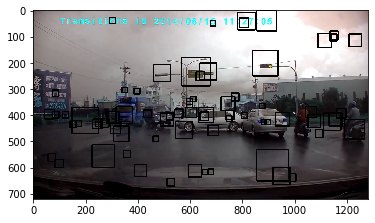

In [9]:
N = 99
frame_with_car, car_point = detect_cars(frames[N])
filtered_frame, f_points = quick_filter(frames[N])
plt.imshow(frame_with_car)

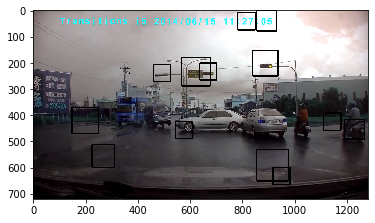

In [10]:
plt.imshow(filtered_frame)

In [11]:
''' Detects all of the cars and stores the points in the array called car_points, and stores the images
    in the array called frames_cars_detected.'''

frames_cars_detected = []
car_points = []
for i in range(len(frames)):
    if i % 10 == 0: print(i)
    frame_with_car, car_point = detect_cars(frames[i])
    car_points.append(car_point)
    frames_cars_detected.append(frame_with_car)

0
10
20
30
40
50
60
70
80
90


In [269]:
'''Stores the car_points which is the most important aspect of the project in a pickled file. '''

'''pickle_out = open("car_points_video_48","wb")
pickle.dump(car_points, pickle_out)
pickle_out.close()'''

In [182]:
'''pickle_in = open("car_points_video_48","rb")
car_points = pickle.load(pickle_in)'''

------frame number: 0----------
Number of Detected Cars: 16
------frame number: 1----------
Number of Detected Cars: 14
Min Dist, Min Index: 91.828645, 1
Old: 0.000000 -- New: 91.828645
Min Dist, Min Index: 8.062258, 1
Old: 0.000000 -- New: 8.062258
Min Dist, Min Index: 11.313708, 4
Old: 0.000000 -- New: 11.313708
Min Dist, Min Index: 3.535534, 5
Old: 0.000000 -- New: 3.535534
Min Dist, Min Index: 166.973052, 5
Old: 0.000000 -- New: 166.973052
Min Dist, Min Index: 2.121320, 7
Old: 0.000000 -- New: 2.121320
Min Dist, Min Index: 39.319207, 9
Old: 0.000000 -- New: 39.319207
Min Dist, Min Index: 119.266508, 10
Old: 0.000000 -- New: 119.266508
Min Dist, Min Index: 2.915476, 9
Old: 0.000000 -- New: 2.915476
Min Dist, Min Index: 2.236068, 10
Old: 0.000000 -- New: 2.236068
Min Dist, Min Index: 2.549510, 13
Old: 0.000000 -- New: 2.549510
Min Dist, Min Index: 1.581139, 15
Old: 0.000000 -- New: 1.581139
Min Dist, Min Index: 2.549510, 15
Old: 0.000000 -- New: 2.549510
Min Dist, Min Index: 233.140516, 12
Old: 0.000000 -- New: 233.140516
------frame number: 2----------
Number of Detected Cars: 10
Min Dist, Min Index: 60.207973, 1
Old: 8.062258 -- New: 60.207973
Min Dist, Min Index: 72.622311, 4
Old: 11.313708 -- New: 72.622311
Min Dist, Min Index: 146.220724, 4
Old: 11.313708 -- New: 146.220724
Min Dist, Min Index: 0.707107, 7
Old: 2.121320 -- New: 0.707107
Min Dist, Min Index: 408.765214, 7
Old: 2.121320 -- New: 408.765214
Min Dist, Min Index: 43.732139, 9
Old: 2.915476 -- New: 43.732139
Min Dist, Min Index: 119.048310, 10
Old: 2.236068 -- New: 119.048310
Min Dist, Min Index: 2.121320, 10
Old: 2.236068 -- New: 2.121320
Min Dist, Min Index: 305.764615, 12
Old: 233.140516 -- New: 305.764615
Min Dist, Min Index: 4.123106, 13
Old: 2.549510 -- New: 4.123106
------frame number: 3----------
Number of Detected Cars: 12
Min Dist, Min Index: 102.002451, 1
Old: 60.207973 -- New: 102.002451
Min Dist, Min Index: 45.803930, 1
Old: 60.207973 -- New: 45.803930
Min Dist, Min Index: 111.671393, 4
Old: 146.220724 -- New: 111.671393
Min Dist, Min Index: 198.909527, 4
Old: 146.220724 -- New: 198.909527
Min Dist, Min Index: 126.589889, 9
Old: 43.732139 -- New: 126.589889
Min Dist, Min Index: 252.286543, 10
Old: 2.121320 -- New: 252.286543
Min Dist, Min Index: 3.000000, 7
Old: 408.765214 -- New: 3.000000
Min Dist, Min Index: 8.062258, 9
Old: 43.732139 -- New: 8.062258
Min Dist, Min Index: 3.162278, 10
Old: 2.121320 -- New: 3.162278
Min Dist, Min Index: 0.707107, 12
Old: 305.764615 -- New: 0.707107
Min Dist, Min Index: 3.162278, 13
Old: 4.123106 -- New: 3.162278
Min Dist, Min Index: 155.012903, 13
Old: 4.123106 -- New: 155.012903
------frame number: 4----------
Number of Detected Cars: 15
Min Dist, Min Index: 18.681542, 1
Old: 45.803930 -- New: 18.681542
Min Dist, Min Index: 306.432701, 4
Old: 198.909527 -- New: 306.432701
Min Dist, Min Index: 131.643458, 9
Old: 8.062258 -- New: 131.643458
Min Dist, Min Index: 250.400679, 10
Old: 3.162278 -- New: 250.400679
Min Dist, Min Index: 2.000000, 7
Old: 3.000000 -- New: 2.000000
Min Dist, Min Index: 8.246211, 9
Old: 8.062258 -- New: 8.246211
Min Dist, Min Index: 111.036030, 10
Old: 3.162278 -- New: 111.036030
Min Dist, Min Index: 1.000000, 10
Old: 3.162278 -- New: 1.000000
Min Dist, Min Index: 0.707107, 12
Old: 0.707107 -- New: 0.707107
Min Dist, Min Index: 126.751726, 10
Old: 3.162278 -- New: 126.751726
Min Dist, Min Index: 121.525717, 10
Old: 3.162278 -- New: 121.525717
Min Dist, Min Index: 128.082005, 13
Old: 155.012903 -- New: 128.082005
Min Dist, Min Index: 192.946884, 13
Old: 155.012903 -- New: 192.946884
Min Dist, Min Index: 44.300113, 13
Old: 155.012903 -- New: 44.300113
Min Dist, Min Index: 359.901375, 13
Old: 155.012903 -- New: 359.901375
------frame number: 5----------

In [23]:
filtered = filtered_points(car_points)
centered = center_carpoints(filtered)
crash_frames = detect_crash(centered)

------frame number: 0----------
Number of Detected Cars: 11
------frame number: 1----------
Number of Detected Cars: 8
Min Dist, Min Index: 3.807887, 13
Old: 0.000000 -- New: 3.807887
Min Dist, Min Index: 1.414214, 15
Old: 0.000000 -- New: 1.414214
Min Dist, Min Index: 16.763055, 16
Old: 0.000000 -- New: 16.763055
Min Dist, Min Index: 1.581139, 17
Old: 0.000000 -- New: 1.581139
Min Dist, Min Index: 2.915476, 19
Old: 0.000000 -- New: 2.915476
Min Dist, Min Index: 5.147815, 20
Old: 0.000000 -- New: 5.147815
Min Dist, Min Index: 30.083218, 21
Old: 0.000000 -- New: 30.083218
Min Dist, Min Index: 30.805844, 21
Old: 0.000000 -- New: 30.805844
------frame number: 2----------
Number of Detected Cars: 8
Min Dist, Min Index: 43.908997, 13
Old: 3.807887 -- New: 43.908997
Min Dist, Min Index: 456.584056, 13
Old: 3.807887 -- New: 456.584056
Min Dist, Min Index: 1.414214, 15
Old: 1.414214 -- New: 1.414214
Min Dist, Min Index: 5.147815, 16
Old: 16.763055 -- New: 5.147815
Min Dist, Min Index: 0.707107

In [15]:
'''num_cars = {}
for i in range(len(car_points)):
    if len(car_points[i]) not in num_cars:
        num_cars[len(car_points[i])] = 1
    else:
        num_cars[len(car_points[i])] += 1'''

In [21]:
'''frames_with_four_cars = []
for i in range(len(car_points)):
    if len(car_points[i]) == 2:
        frames_with_four_cars.append(i)'''

In [24]:
out_video =  np.empty([100, 720, 1280], dtype = np.uint8)
out_video =  out_video.astype(np.uint8)

for i in range(len(frames_cars_detected)):
  out_video[i] = frames_cars_detected[i]

# Writes the the output image sequences in a video file
skvideo.io.vwrite("outputvideo5.avi", out_video)


In [66]:
skvideo.io.vwrite("luma.mp4", frames_cars_detected)